# Курсовая работа по эконометрике


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, HuberRegressor

from sklego.linear_model import LADRegression
from scipy.stats import shapiro
from scipy.stats import normaltest
from statsmodels.stats.stattools import durbin_watson
from statsmodels. stats.diagnostic import het_white

In [2]:
from scipy.stats import f
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from random import randrange

## Модельная часть

Вариант 1:

$f(h) = 0.2*h+1+sin(2*h)$

$-5 < h < 5$

$\sigma^2 =0.25$


Смоделировать данные самостоятельно в соответствии с вариантом
$X_k = f(h_k) + e_k, k=1,…,60$
где $e_k $— независимый случайные величины с распределением $N(0,σ^2)$.
Точки внутри носителя для h выбирать равномерно.
Смоделировать тестовую выборку объема 40, половина значений правее наблюдаемых
значений, половина левее.

In [3]:
def f(h):
    return -0.1 * h + 2 + np.cos(1.5 * h)


k = 60
k_test = 40
h_min, h_max = -1, 1.5
sigma_2 = 0.5
sigma = sigma_2 **0.5

In [4]:
def f(h):
    return 0.2*h+1+np.sin(2*h)


k = 100
k_test = 40
h_min, h_max = -5, 5
sigma_2 = 0.25
sigma = sigma_2 **0.5

In [5]:

h_common, step = np.linspace(h_min, h_max, k, retstep=True)
eps = np.random.normal(0, sigma, k)
Y_common =  f(h_common) + eps 
h_test = np.array([*h_common[:20],*h_common[-20:]])
h  = np.array(h_common[20:-20])
Y_test = np.array([*Y_common[:20], *Y_common[-20:]])
Y = np.array(Y_common[20:-20])
Y_true = f(h)
Y_true_test = f(h_test)

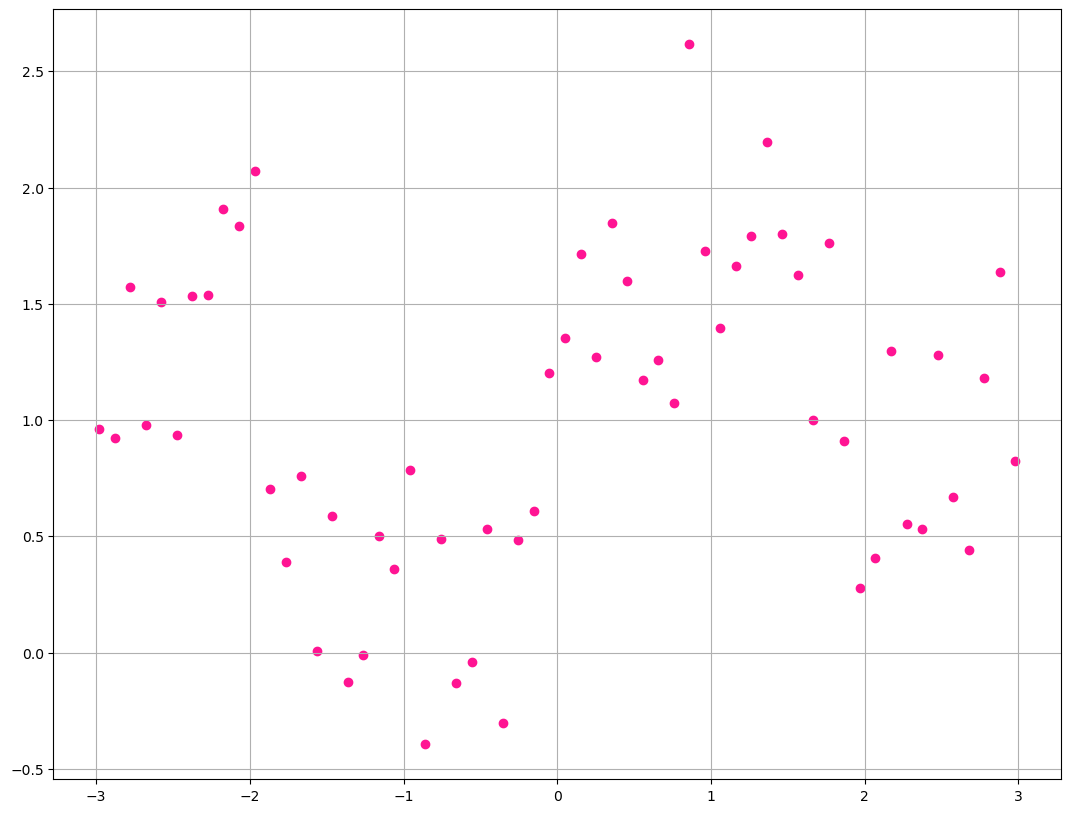

In [6]:
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink')
plt.grid()

## Метод наименьших квадратов

#### Найти МНК-оценки неизвестных параметров.

In [7]:
H = np.array([np.ones(h.size), h]).T
theta =  np.linalg.lstsq(H, Y, rcond=None)[0]
print(f'theta = {theta}')

theta = [1.01695361 0.04316177]


#### Построить график, на котором отобразить наблюдения, исходную функцию и линию регрессию.

In [8]:
Y_LR = theta[0] + theta[1] * h

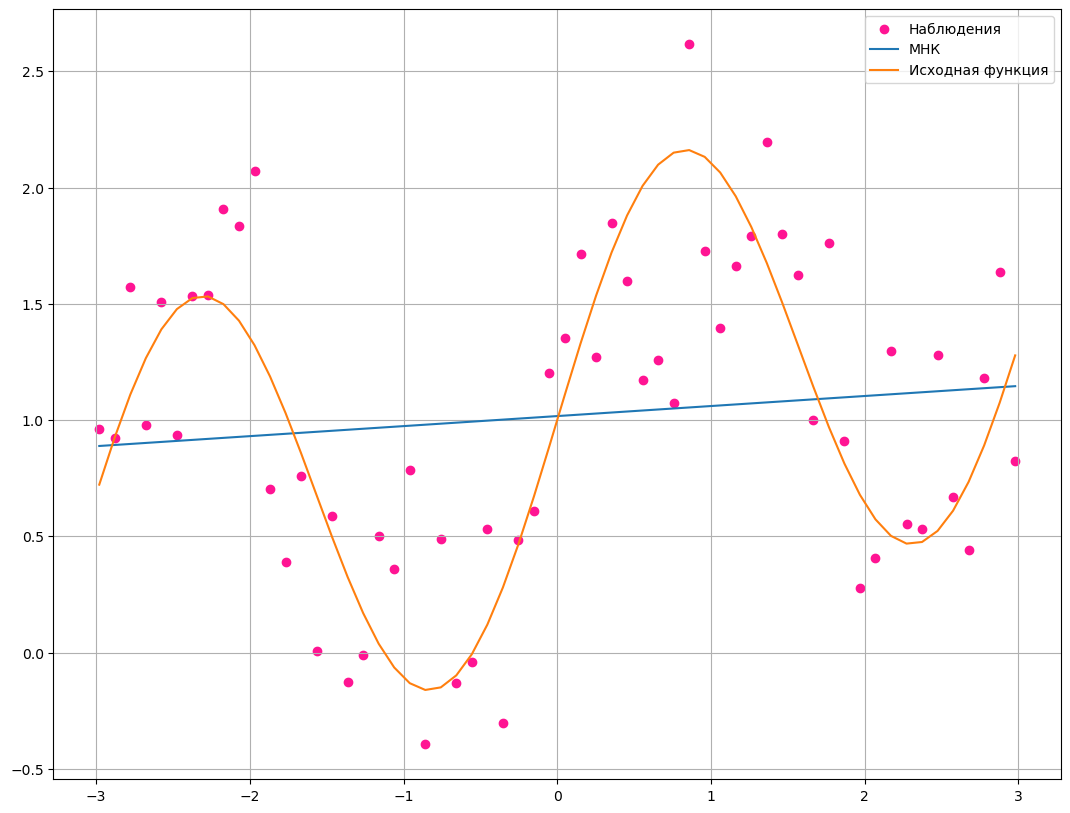

In [9]:
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR, label = 'МНК')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()

#### Вычислить коэффициент детерминации и найти оценку ковариационной матрицы МНК-оценки.

In [10]:
R_2 = 1 - sum((Y - Y_LR)**2)/sum((Y- np.mean(Y))**2)
print(f'Коэффициент детерминации МНК-оценки \n{R_2}')


Коэффициент детерминации МНК-оценки 
0.012620250361104923


In [11]:
K = sum((Y - Y_LR)**2)/(Y.size-2)*np.linalg.inv((H.T@H))
print(f'Ковариационная матрица МНК-оценки \n{K}')

Ковариационная матрица МНК-оценки 
[[7.68983450e-03 7.06788295e-19]
 [7.06788295e-19 2.51296698e-03]]


#### Найти значения информационных критериев

In [12]:
l = -(Y.size/2) *(1 + np.log(2*np.pi) + np.log(sum((Y - Y_LR)**2)/(Y.size-2))) 
l

-61.93096832678834

#### С помощью критерия Фишера проверить гипотезу $\theta_0 = 0, \theta_1 =0$

In [13]:
from scipy.stats import f


In [14]:
def Fisher(Z, H, theta, A, alpha=0.05):
    q, p = A.shape
    N = len(Z)
    F = ((A @ theta).T @ np.linalg.inv(A @ np.linalg.inv(H.T @ H) @ A.T) @ (A @ theta)) / (q / (N - p) * (Z - H @ theta).T @ (Z - H @ theta))
    p_value = f.sf(F, q, N-p)
    return F, p_value, p_value > alpha

In [15]:
print(Fisher(Y, H, theta, np.array([[1,0],[0,1]])))


(67.61493771619887, 6.970402714094327e-16, False)


#### Построить доверительный интервал надежности 0.95 и 0.8 для полезного сигнала $Y = θ_1 + θ_2h$ при h из исходного носителя $±50\%$.

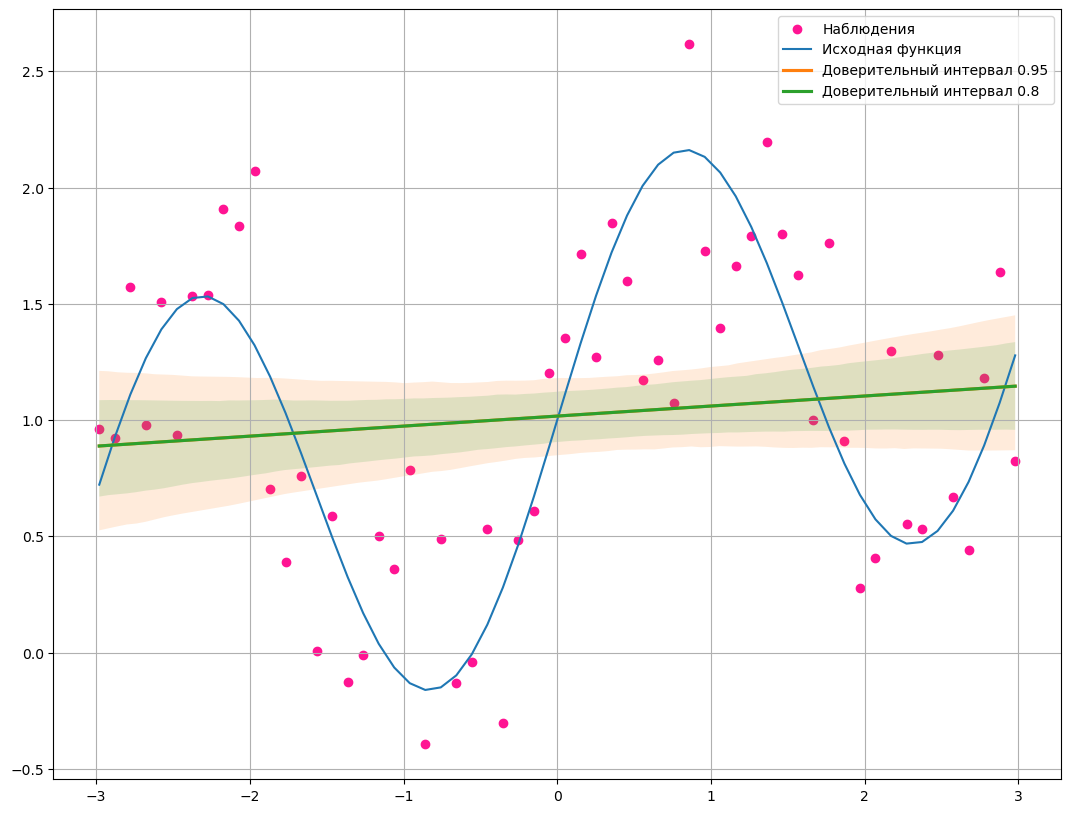

In [16]:

plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h, Y_true, label = 'Исходная функция')

sns.regplot(x = h,y = Y,scatter=False, label ='Доверительный интервал 0.95');
sns.regplot(x = h,y = Y,scatter=False,ci = 80, label ='Доверительный интервал 0.8');

plt.legend()
plt.grid()

#### Построить оценку метода наименьших модулей, отобразить ее на графике

In [17]:
modelLAD = LADRegression().fit(H, Y)
thetaLAD = modelLAD.coef_
Y_MNM =modelLAD.predict(H)

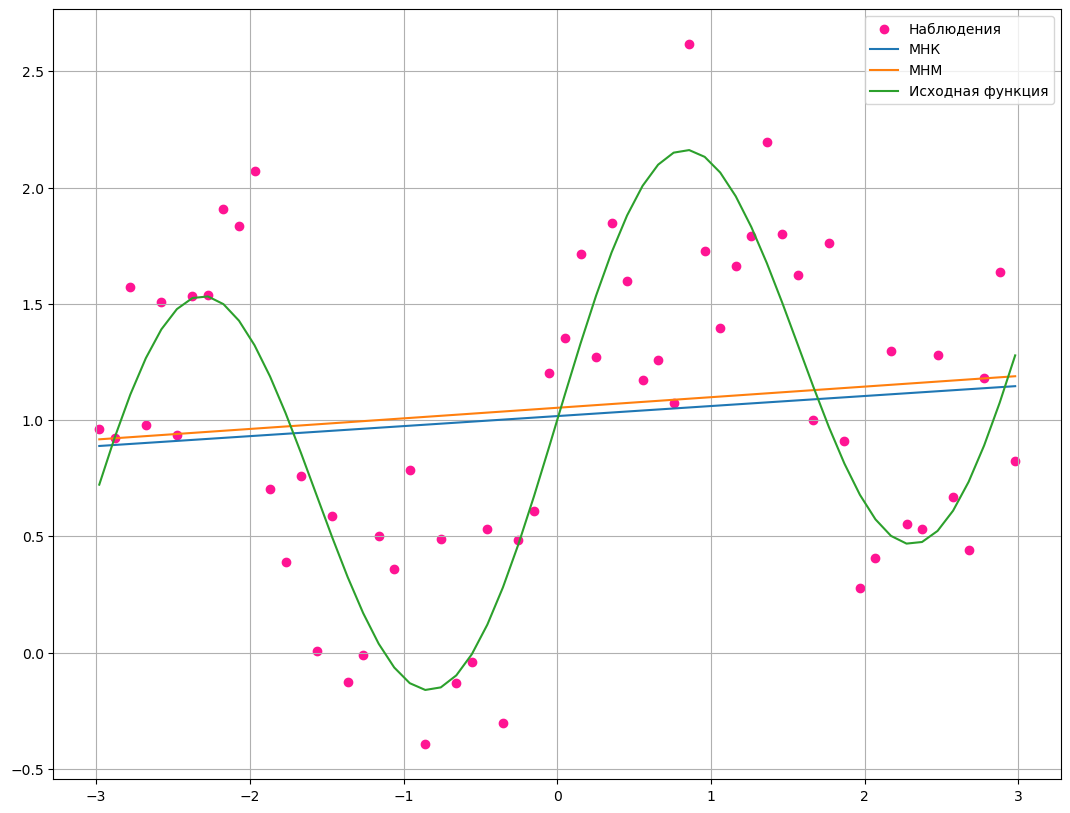

In [18]:
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR, label = 'МНК')
plt.plot(h,Y_MNM, label = 'МНМ')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()

#### Оценить качество построенных регрессий на тестовой выборке

In [19]:
MNK_test = theta[0]+theta[1]*h_test
MSE_MNK =np.sum((Y_test - MNK_test) ** 2)
MSE_MNK


64.25808451495975

In [20]:
MNM_test = thetaLAD[0]+thetaLAD[1]*h_test
MSE_MNM =np.sum((Y_test - MNM_test) ** 2)
MSE_MNM

75.18778030539156

 #### Для остатков $\hat{e}_k = X_k- \hat{X}_k$:
 #### Построить гистограмму, ядерную оценку плотности распределения

In [21]:
Y_LR_test = theta[0] + theta[1] * h_test
hat_eps = Y_test - Y_LR_test

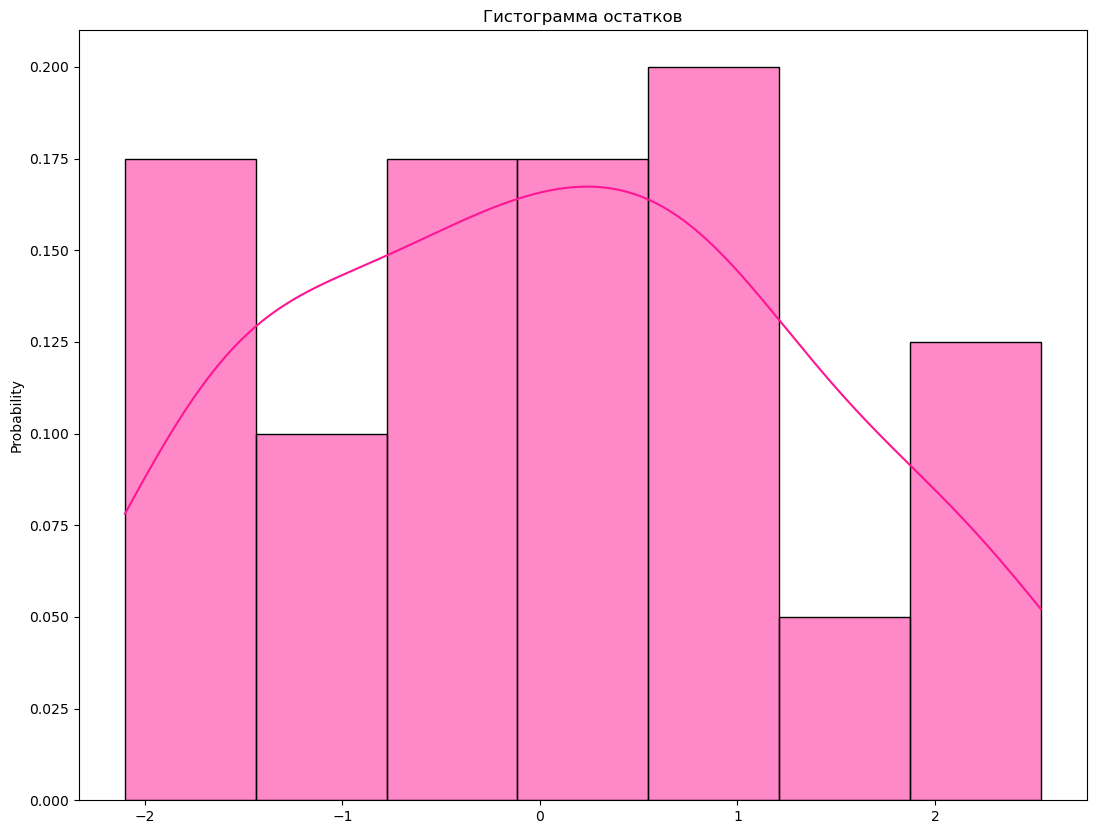

In [22]:
plt.figure(figsize=(13,10))
plt.title("Гистограмма остатков")
sns.histplot(hat_eps, color="deeppink", kde=True, stat='probability')
plt.show()

In [23]:
print("\nПроверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:")
print(shapiro(hat_eps))
print("\nПроверка гипотезы о нормальном распределении, критерий D'Agostino:")
print(normaltest(hat_eps))
print("\nПроверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:")
print(durbin_watson(hat_eps))


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.9666222333908081, pvalue=0.2798737585544586)

Проверка гипотезы о нормальном распределении, критерий D'Agostino:
NormaltestResult(statistic=3.4229866505194595, pvalue=0.18059590272723586)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
0.3566590272210225


In [24]:
H_test = np.array([np.ones(h_test.size), h_test]).T
geter = het_white(hat_eps,H_test)
print(f'LM Statistic {geter[0]}\nLM-Test p-value {geter[1]}\nF-Statistic {geter[2]}\nF-Test p-value {geter[3]}')

LM Statistic 0.47585280589251155
LM-Test p-value 0.7882607026243009
F-Statistic 0.22273160925592134
F-Test p-value 0.8013948709362371


## Полиномиальная регрессия

Построить регрессию с помощью МНК
$X = \theta_0 + \theta_1 h + \theta_2 h^2 + … + \theta_ph^p$

theta = [0.94590776 0.04316177 0.02321713]
(0.5203333377177382, 0.4736480413627392, True)
21.185919183993644
Критерий Фишера <F test: F=0.5203333377177385, p=0.4736480413627392, df_denom=57, df_num=1>


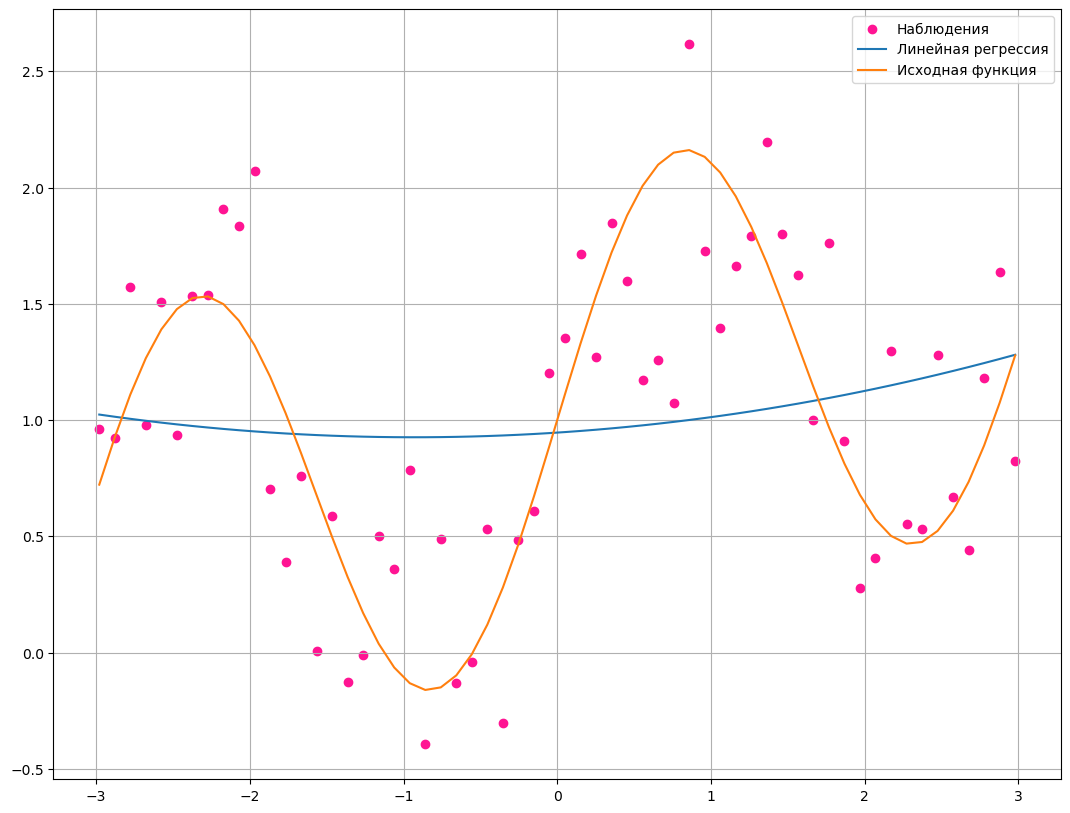

In [25]:
H2 = np.array([np.ones(h.size), h, h**2]).T
H2_test = np.array([np.ones(h_test.size), h_test, h_test**2]).T
res = sm.OLS(Y, H2).fit()
ypred = res.predict(H2) 
theta2 = res.params
print(f'theta = {theta2}')
Y_LR2 = ypred
print(Fisher(Y, H2, theta2, np.array([[0 for _ in range(2)] + [1]])))
res_test = sm.OLS(Y_test, H2_test).fit()
ypred = res_test.predict(H2_test) 
theta_test2 = res_test.params
MNK_test2 = theta_test2[0] + theta_test2[1] * h_test + theta_test2[2] *h_test**2
print(np.sum((Y_test - MNK_test2) ** 2))
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR2, label = 'Линейная регрессия')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()
fish = res.f_test('x2=0')
print(f'Критерий Фишера {fish}')

theta = [ 0.94590776  0.45597465  0.02321713 -0.07497413]
(16.185309434494986, 0.00017391010326937037, False)
18.11229031270603
Критерий Фишера <F test: F=16.185309434494954, p=0.00017391010326937183, df_denom=56, df_num=1>


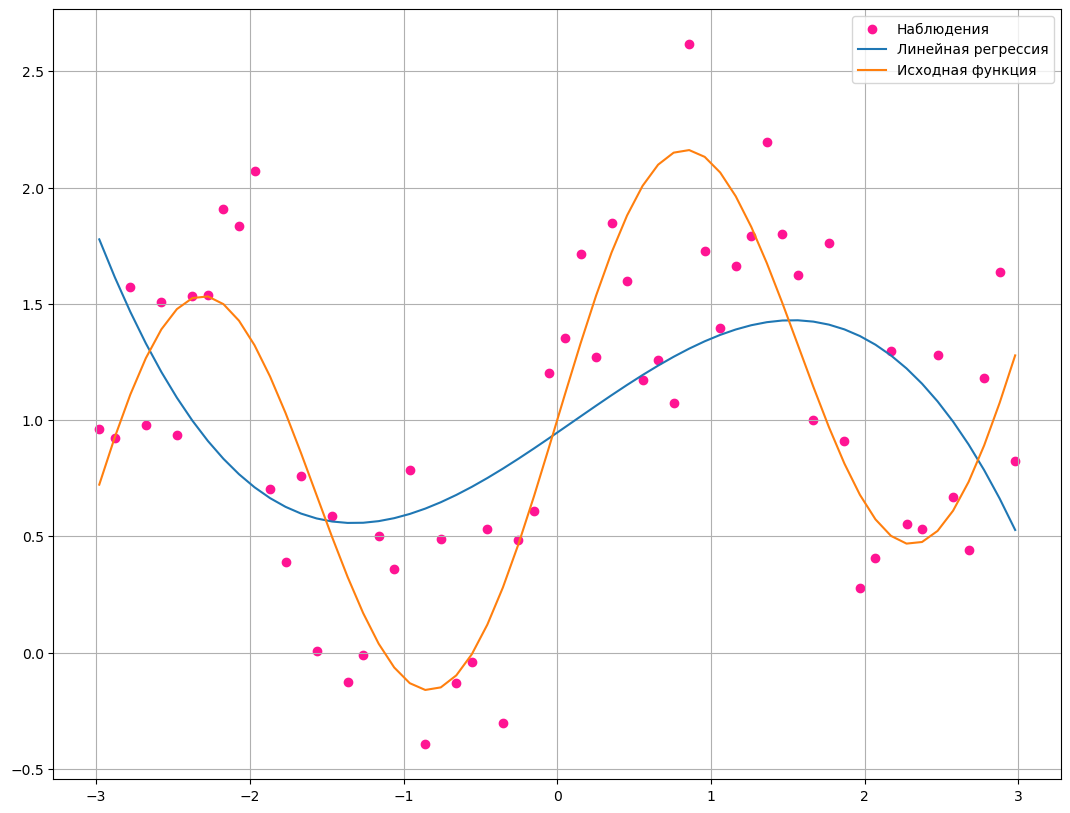

In [26]:
H3 = np.array([np.ones(h.size), h, h**2, h**3]).T
H3_test = np.array([np.ones(h_test.size), h_test, h_test**2, h_test**3]).T
res = sm.OLS(Y, H3).fit()
ypred = res.predict(H3) 
theta3 = res.params
print(f'theta = {theta3}')
Y_LR3 = ypred
print(Fisher(Y, H3, theta3, np.array([[0 for _ in range(3)] + [1]])))
res_test = sm.OLS(Y_test, H3_test).fit()
ypred = res_test.predict(H3_test) 
theta_test3 = res_test.params
MNK_test3 = theta_test3[0] + theta_test3[1] * h_test + theta_test3[2] *h_test**2+ theta_test3[3] *h_test**3
print(np.sum((Y_test - MNK_test3) ** 2))
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR3, label = 'Линейная регрессия')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()
fish = res.f_test('x3=0')
print(f'Критерий Фишера {fish}')

theta = [ 0.91155294  0.45597465  0.06068857 -0.07497413 -0.00476648]
(0.14957723942849846, 0.7004320462737729, True)
18.10284579077085
Критерий Фишера <F test: F=0.14957723942849888, p=0.7004320462737729, df_denom=55, df_num=1>


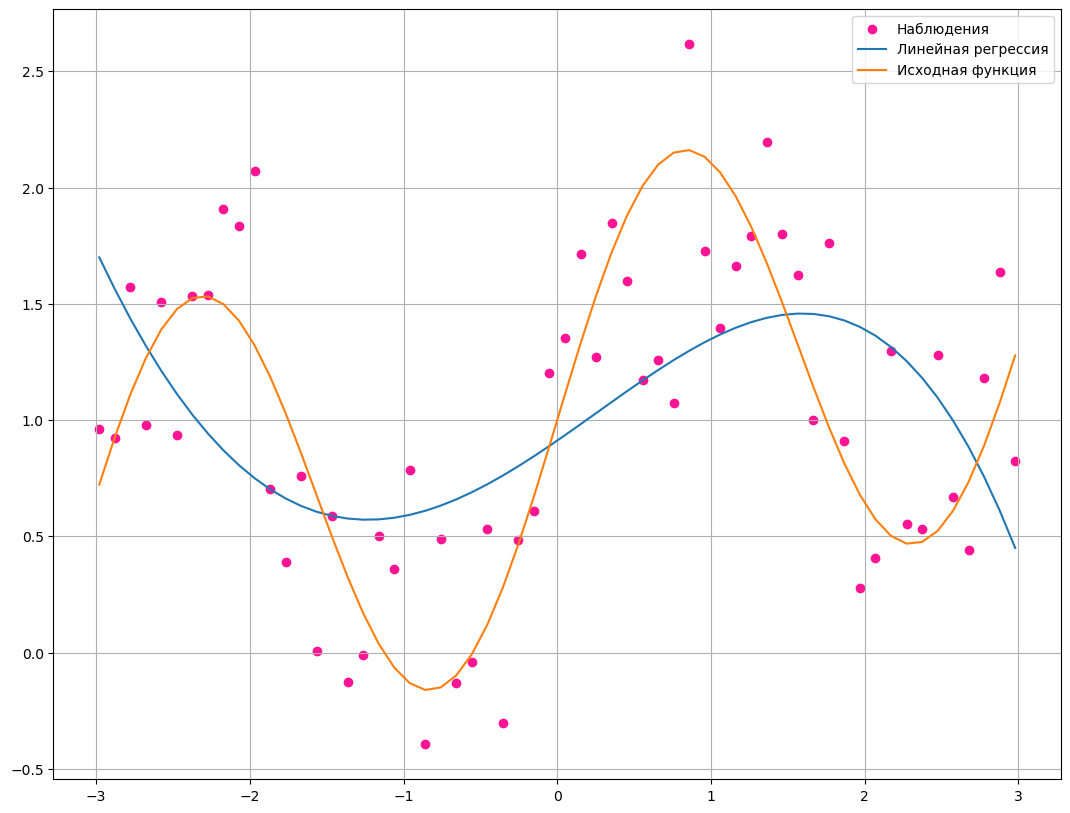

In [27]:
H4 = np.array([np.ones(h.size), h, h**2, h**3, h**4]).T
H4_test = np.array([np.ones(h_test.size), h_test, h_test**2, h_test**3, h_test**4]).T
res = sm.OLS(Y, H4).fit()
ypred = res.predict(H4) 
theta4 = res.params
print(f'theta = {theta4}')
Y_LR4 = ypred
print(Fisher(Y, H4, theta4, np.array([[0 for _ in range(4)] + [1]])))
res_test = sm.OLS(Y_test, H4_test).fit()
ypred = res_test.predict(H4_test) 
theta_test4 = res_test.params
MNK_test4 = theta_test4[0] + theta_test4[1] * h_test + theta_test4[2] *h_test**2 + theta_test4[3] *h_test**3 + theta_test4[4] *h_test**4
print(np.sum((Y_test - MNK_test4) ** 2))
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR4, label = 'Линейная регрессия')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()
fish = res.f_test('x4=0')
print(f'Критерий Фишера {fish}')

theta = [ 0.91155294  1.28191638  0.06068857 -0.49569262 -0.00476648  0.04131495]
(47.98551124696456, 5.410011393527745e-09, False)
3418.211203025123
Критерий Фишера <F test: F=47.98551124696777, p=5.410011393523061e-09, df_denom=54, df_num=1>


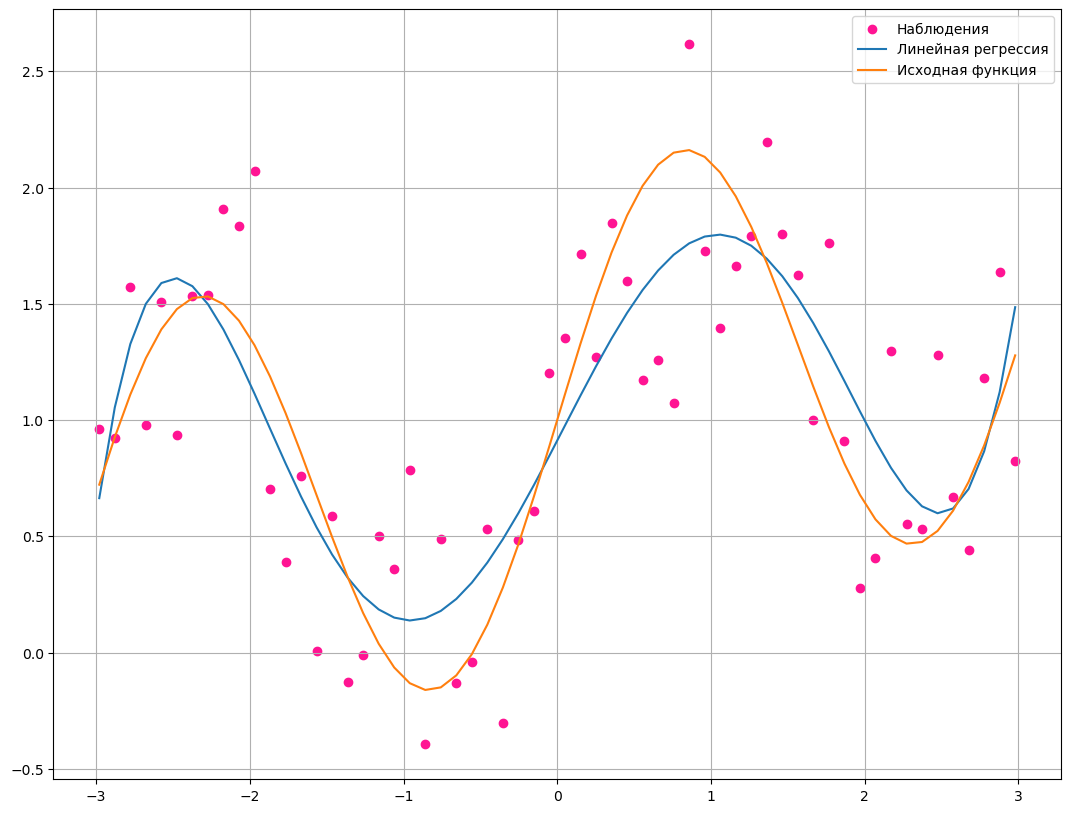

In [28]:
H5 = np.array([np.ones(h.size), h, h**2, h**3, h**4, h**5]).T
H5_test = np.array([np.ones(h_test.size), h_test, h_test**2, h_test**3, h_test**4, h_test**5]).T
res = sm.OLS(Y, H5).fit()
ypred = res.predict(H5) 
theta5 = res.params
print(f'theta = {theta5}')
Y_LR5 = ypred
print(Fisher(Y, H5, theta5, np.array([[0 for _ in range(5)] + [1]])))
res_test = sm.OLS(Y_test, H5_test).fit()
ypred = res_test.predict(H5_test) 
theta_test5 = res_test.params
MNK_test5 = theta_test5[0] + theta_test5[1] * h_test + theta_test5[2] *h_test**2 + theta_test5[3] *h_test**3 + theta_test5[4] *h_test**4
print(np.sum((Y_test - MNK_test5) ** 2))
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR5, label = 'Линейная регрессия')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()
fish = res.f_test('x5=0')
print(f'Критерий Фишера {fish}')

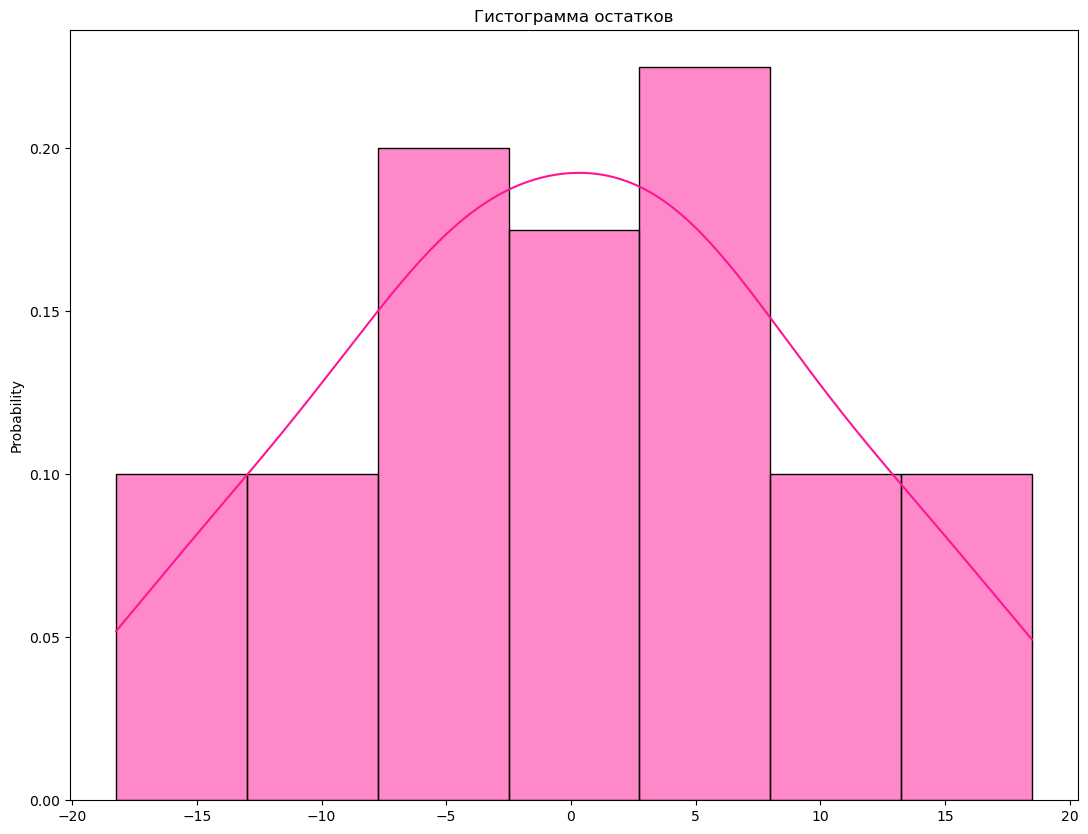

In [29]:
hat_eps = Y_test - MNK_test5
plt.figure(figsize=(13,10))
plt.title("Гистограмма остатков")
sns.histplot(hat_eps, color="deeppink", kde=True, stat='probability')
plt.show()

In [30]:
print("\nПроверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:")
print(shapiro(hat_eps))
print("\nПроверка гипотезы о нормальном распределении, критерий D'Agostino:")
print(normaltest(hat_eps))
print("\nПроверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:")
D = durbin_watson(hat_eps)
print(D)


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.9848925471305847, pvalue=0.8610321879386902)

Проверка гипотезы о нормальном распределении, критерий D'Agostino:
NormaltestResult(statistic=0.9373643886694085, pvalue=0.6258264427442811)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
0.02005632827478433


In [31]:
geter = het_white(hat_eps,H_test)
print(f'LM Statistic {geter[0]}\nLM-Test p-value {geter[1]}\nF-Statistic {geter[2]}\nF-Test p-value {geter[3]}')

LM Statistic 33.734936057579866
LM-Test p-value 4.726631135154426e-08
F-Statistic 99.61531483175011
F-Test p-value 1.2735384325746111e-15


#### Проверить для подобранной модели является ли матрица $H^TH$ мультиколлиниарной,если да, то построить оценку параметров с помощью метода редукции (ридж-оценка).

In [32]:
ev = np.linalg.eigvals(H5.T @ H5)
print(ev)
cond_num = max(ev) / min(ev)
print(cond_num)

[4.81965056e+04 1.29890927e+01 1.05709110e+02 3.60758699e+05
 8.22863338e+00 3.70000612e+02]
43841.87284570927


In [33]:
H5[0].size

6

In [34]:
[variance_inflation_factor(H5, i) for i in range(H5[0].size)]

[3.520197672096057,
 19.23694103852458,
 12.301288567556053,
 127.72042073541478,
 12.301288567556053,
 62.652801014519234]

Коэффициенты Ридж оценка[ 0.          1.20891118  0.05986126 -0.46625808 -0.00466972  0.03875507]


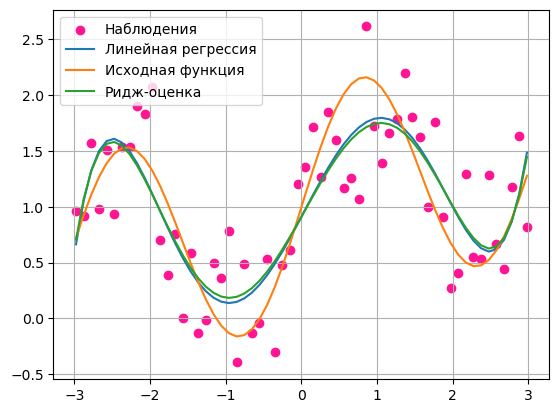

In [35]:
model_ridge = Ridge(alpha=0.5).fit(H5, Y)

print(f'Коэффициенты Ридж оценка{model_ridge.coef_}')
plt.figure()
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR5, label = 'Линейная регрессия')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.plot(h, model_ridge.predict(H5), label = 'Ридж-оценка')
plt.legend()
plt.grid()

## Регрессия для наблюдений с выбросами

Смоделировать ошибки для модели регрессии (1) с помощью распределения Тьюки,
приняв долю выбросов$\sigma =0.08$ номинальную дисперсию $\sigma_0^2 =\sigma^2$, дисперсию аномальных наблюдений $\sigma_1^2 =100\sigma^2$

In [36]:
lam = 0.08
tukey = []
def f(h):
    return 0.2*h+1+np.sin(2*h)
for hh in h_common: 
    if np.random.uniform() > lam:
        tukey.append(f(hh) + np.random.normal(0, sigma))
    else: 
        tukey.append(f(hh) + np.random.normal(0, 100**0.5 * sigma))
tukey = np.array(tukey)

In [37]:
Y_common_tukey =  tukey 
Y_test_tukey = np.array([*Y_common_tukey[:20], *Y_common_tukey[-20:]])
Y_tukey = np.array(Y_common_tukey[20:-20])
Y_true_tukey = f(h)
Y_true_test_tukey = f(h_test)

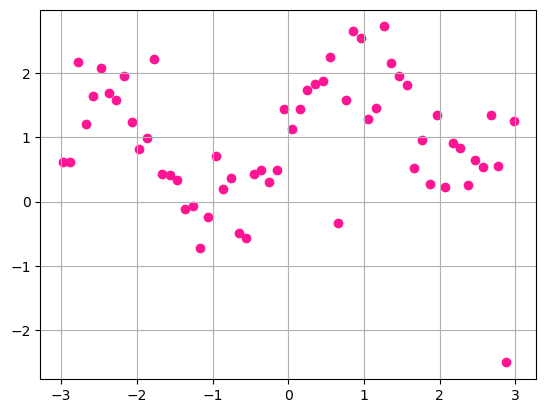

In [38]:
plt.figure()
plt.scatter(h, Y_tukey, color = 'deeppink')
plt.grid()

#### Построить МНК-оценку неизвестных параметров для модели (1) и оценить ее качество.

In [39]:
H = np.array([np.ones(h.size), h]).T
theta_tukey =  np.linalg.lstsq(H, Y_tukey, rcond=None)[0]
print(f'theta_tukey = {theta_tukey}')

theta_tukey = [ 0.95460251 -0.03302672]


In [40]:
Y_LR_tukey = theta_tukey[0] + theta_tukey[1] * h
Y_LR_test_tukey = theta_tukey[0]+theta_tukey[1]*h_test
MSE_MNK =np.sum((Y_test - Y_LR_test_tukey) ** 2)
MSE_MNK

94.32952197000358

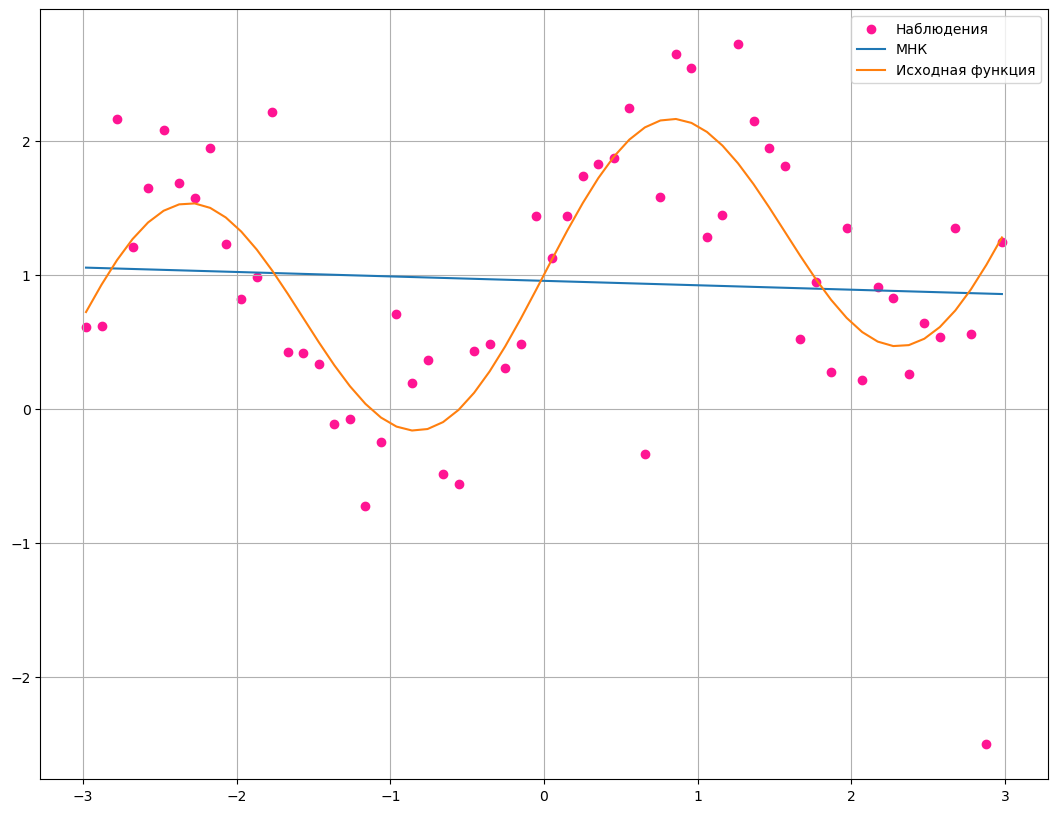

In [41]:
plt.figure(figsize=(13,10))
plt.scatter(h, Y_tukey, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR_tukey, label = 'МНК')
plt.plot(h, Y_true_tukey, label = 'Исходная функция')
plt.legend()
plt.grid()

In [42]:
hat_eps = Y_test_tukey - Y_LR_test_tukey

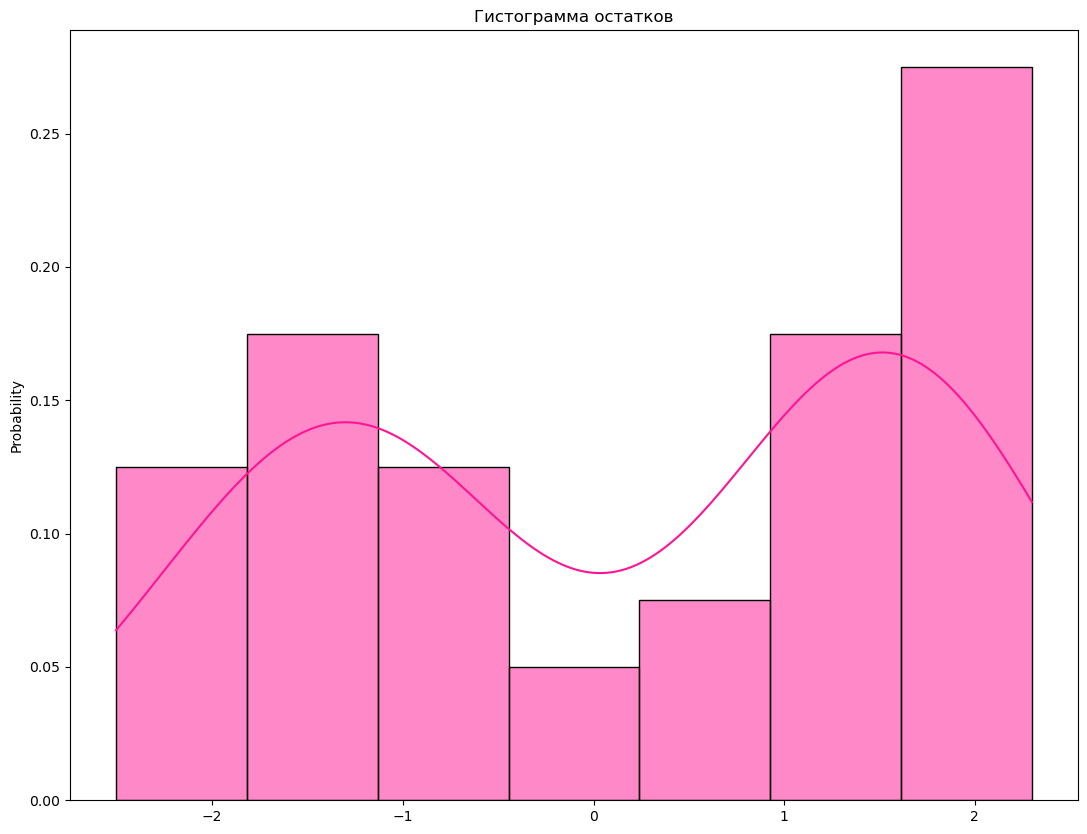

In [43]:
plt.figure(figsize=(13,10))
plt.title("Гистограмма остатков")
sns.histplot(hat_eps, color="deeppink", kde=True, stat='probability')
plt.show()

In [44]:
print("\nПроверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:")
print(shapiro(hat_eps))
print("\nПроверка гипотезы о нормальном распределении, критерий D'Agostino:")
print(normaltest(hat_eps))
print("\nПроверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:")
print(durbin_watson(hat_eps))


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.8786720633506775, pvalue=0.00048477345262654126)

Проверка гипотезы о нормальном распределении, критерий D'Agostino:
NormaltestResult(statistic=38.360389980543616, pvalue=4.678936528815365e-09)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
0.3013970072611362


In [45]:
H_test = np.array([np.ones(h_test.size), h_test]).T
geter = het_white(hat_eps,H_test)
print(f'LM Statistic {geter[0]}\nLM-Test p-value {geter[1]}\nF-Statistic {geter[2]}\nF-Test p-value {geter[3]}')

LM Statistic 0.7376954076126463
LM-Test p-value 0.6915307199274442
F-Statistic 0.34759459951518185
F-Test p-value 0.7086670449397008


####  Отбраковка остатков

In [46]:
e_hat = Y_tukey - Y_LR_tukey
s2 = 2* np.median(abs(hat_eps))/ 0.675
h_new_tukey = []
Y_new_tukey = []
for i in range(k-k_test):
    if e_hat[i] <= s2:
        Y_new_tukey.append(Y_tukey[i])
        h_new_tukey.append(h[i])
h_new_tukey = np.array(h_new_tukey)
Y_new_tukey = np.array(Y_new_tukey)

In [47]:
H_new = np.array([np.ones(h_new_tukey.size), h_new_tukey]).T
theta_tukey =  np.linalg.lstsq(H_new, Y_new_tukey, rcond=None)[0]
print(f'theta_tukey = {theta_tukey}')

theta_tukey = [ 0.95460251 -0.03302672]


In [48]:
Y_LR_tukey = theta_tukey[0] + theta_tukey[1] * h_new_tukey
Y_LR_test_tukey = theta_tukey[0]+theta_tukey[1]*h_test
MSE_MNK =np.sum((Y_test - Y_LR_test_tukey) ** 2)
MSE_MNK

94.32952197000358

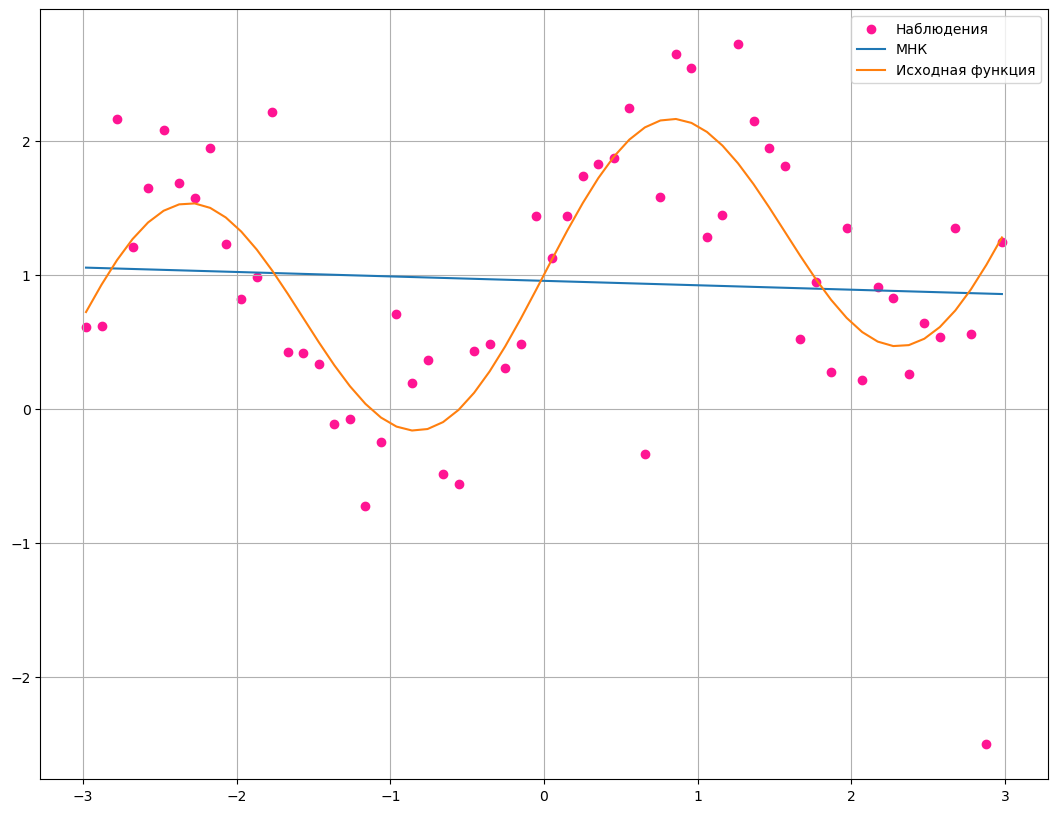

In [49]:
plt.figure(figsize=(13,10))
plt.scatter(h, Y_tukey, color = 'deeppink', label='Наблюдения')
plt.plot(h_new_tukey,Y_LR_tukey, label = 'МНК')
plt.plot(h, Y_true_tukey, label = 'Исходная функция')
plt.legend()
plt.grid()

In [50]:
hat_eps = Y_test_tukey - Y_LR_test_tukey

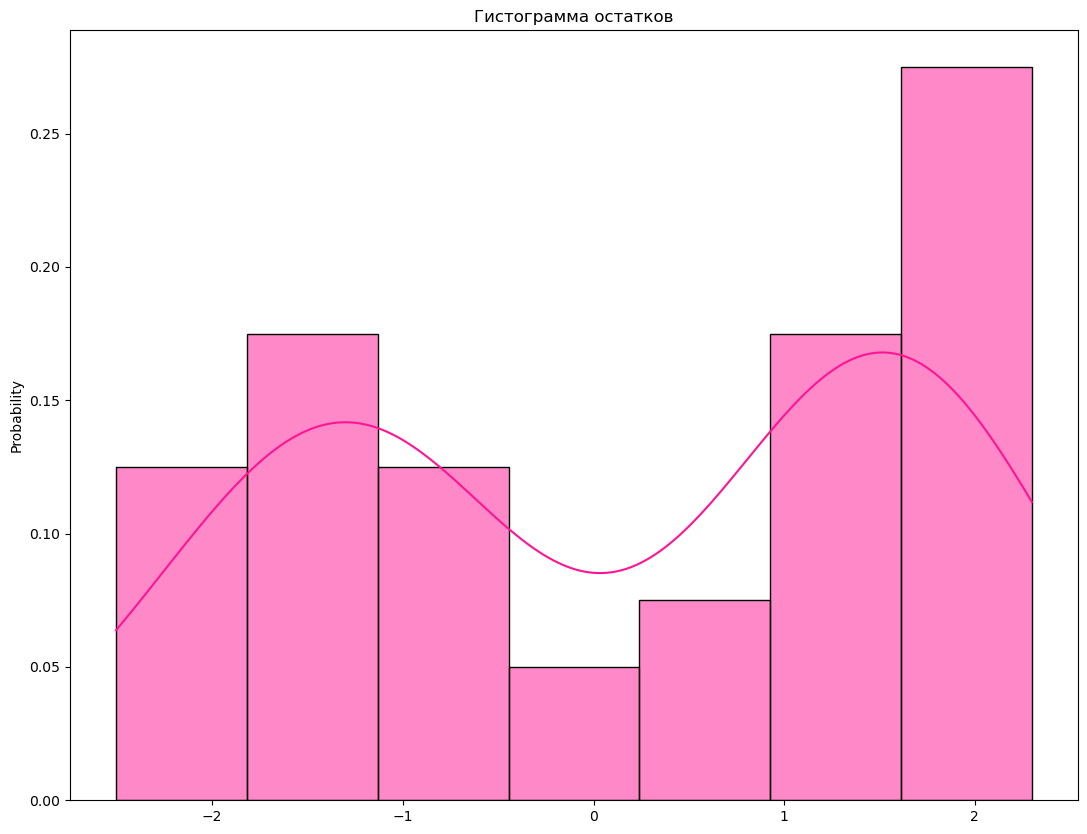

In [51]:
plt.figure(figsize=(13,10))
plt.title("Гистограмма остатков")
sns.histplot(hat_eps, color="deeppink", kde=True, stat='probability')
plt.show()

In [52]:
print("\nПроверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:")
print(shapiro(hat_eps))
print("\nПроверка гипотезы о нормальном распределении, критерий D'Agostino:")
print(normaltest(hat_eps))
print("\nПроверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:")
print(durbin_watson(hat_eps))


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.8786720633506775, pvalue=0.00048477345262654126)

Проверка гипотезы о нормальном распределении, критерий D'Agostino:
NormaltestResult(statistic=38.360389980543616, pvalue=4.678936528815365e-09)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
0.3013970072611362


In [53]:
H_test = np.array([np.ones(h_test.size), h_test]).T
geter = het_white(hat_eps,H_test)
print(f'LM Statistic {geter[0]}\nLM-Test p-value {geter[1]}\nF-Statistic {geter[2]}\nF-Test p-value {geter[3]}')

LM Statistic 0.7376954076126463
LM-Test p-value 0.6915307199274442
F-Statistic 0.34759459951518185
F-Test p-value 0.7086670449397008


#### Построить оценку метода наименьших модулей.

In [54]:
modelLAD_tukey = LADRegression().fit(H, Y_tukey)
thetaLAD_tukey = modelLAD_tukey.coef_
Y_MNM_tukey =modelLAD_tukey.predict(H)
thetaLAD_tukey

array([ 0.47440008, -0.0199769 ])

In [55]:
Y_LAD_tukey = thetaLAD_tukey[0] + thetaLAD_tukey[1] * h_new_tukey
Y_LAD_test_tukey = thetaLAD_tukey[0]+thetaLAD_tukey[1]*h_test
MSE_MNM =np.sum((Y_test - Y_LAD_test_tukey) ** 2)
MSE_MNM

102.37339725362997

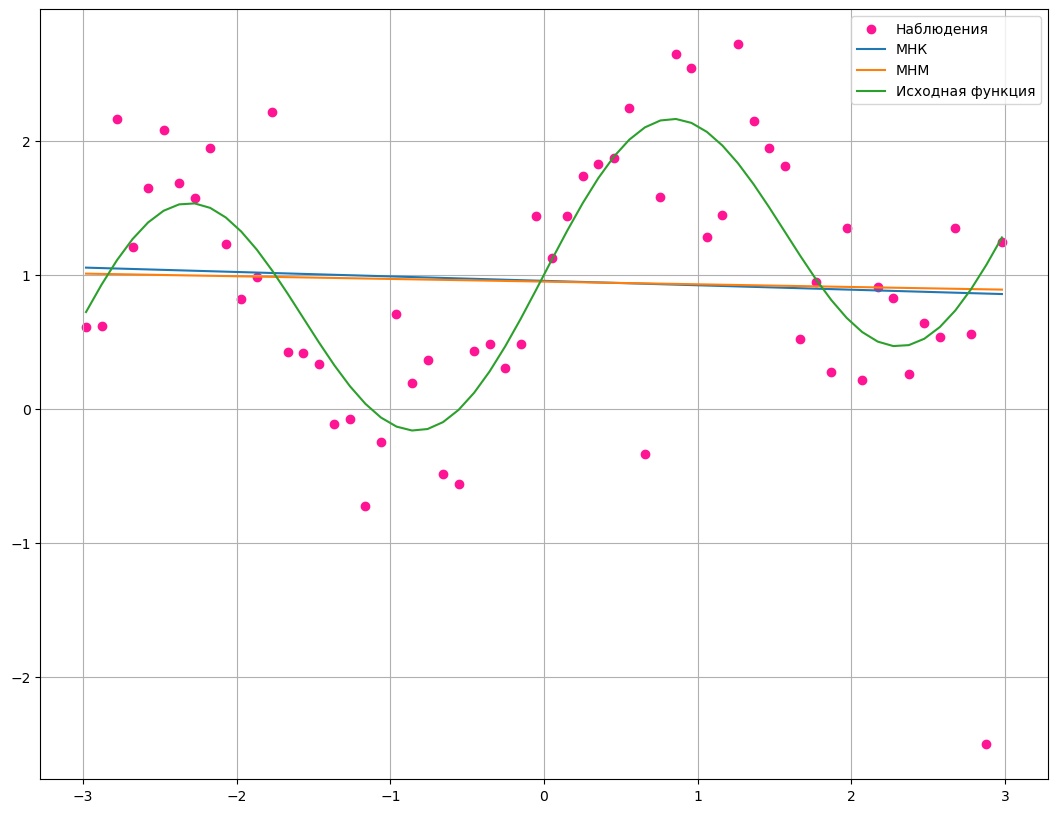

In [56]:
plt.figure(figsize=(13,10))
plt.scatter(h, Y_tukey, color = 'deeppink', label='Наблюдения')
plt.plot(h_new_tukey,Y_LR_tukey, label = 'МНК')
plt.plot(h,Y_MNM_tukey, label = 'МНМ')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()

In [57]:
hat_eps = Y_test_tukey - Y_LAD_test_tukey

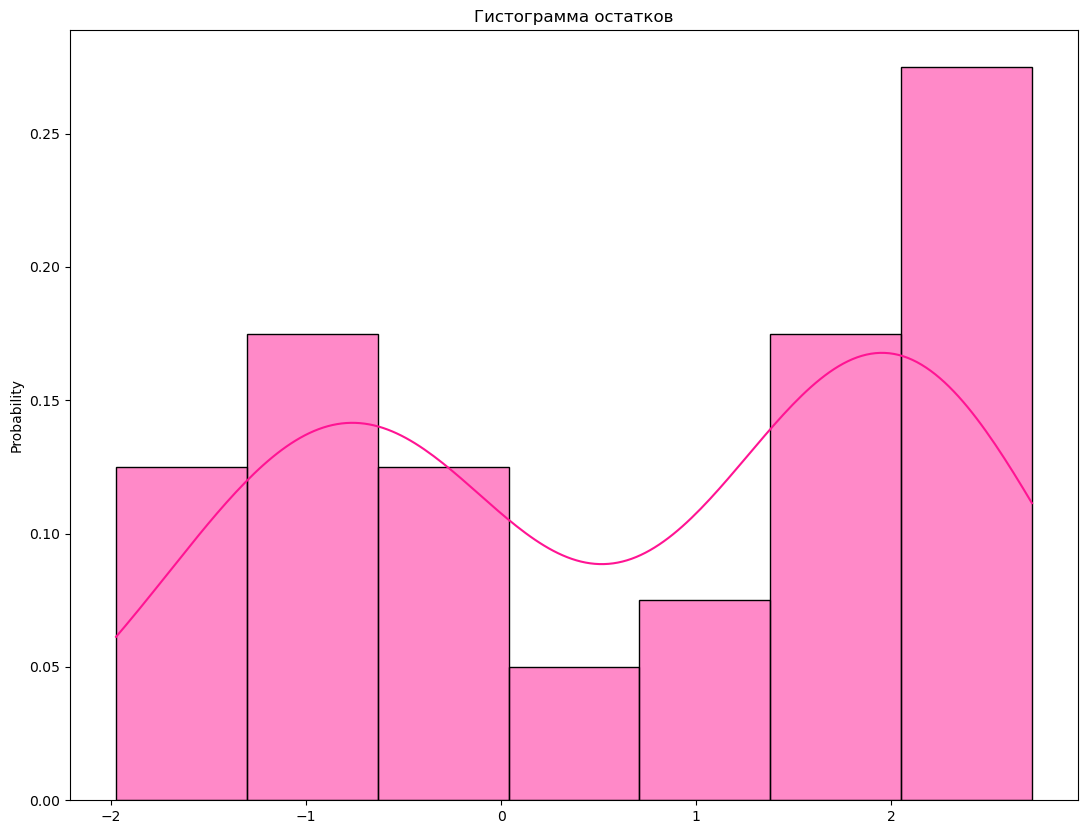

In [58]:
plt.figure(figsize=(13,10))
plt.title("Гистограмма остатков")
sns.histplot(hat_eps, color="deeppink", kde=True, stat='probability')
plt.show()

In [59]:
print("\nПроверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:")
print(shapiro(hat_eps))
print("\nПроверка гипотезы о нормальном распределении, критерий D'Agostino:")
print(normaltest(hat_eps))
print("\nПроверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:")
print(durbin_watson(hat_eps))


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.8839256763458252, pvalue=0.0006728231091983616)

Проверка гипотезы о нормальном распределении, критерий D'Agostino:
NormaltestResult(statistic=34.34914151802766, pvalue=3.476791844891835e-08)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
0.27158427305221455


In [60]:
H_test = np.array([np.ones(h_test.size), h_test]).T
geter = het_white(hat_eps,H_test)
print(f'LM Statistic {geter[0]}\nLM-Test p-value {geter[1]}\nF-Statistic {geter[2]}\nF-Test p-value {geter[3]}')

LM Statistic 18.870695140797224
LM-Test p-value 7.985104707230058e-05
F-Statistic 16.522448913064746
F-Test p-value 7.4518916555612615e-06


####  робастая оценка Хубера

In [61]:
huber = HuberRegressor().fit(H, Y_tukey)
Y_huber = huber.predict(H)
huber_theta = huber.coef_
huber_theta

array([ 0.49415107, -0.01340154])

In [62]:
Y_huber_tukey = huber_theta[0] + huber_theta[1] * h
Y_huber_test_tukey = huber_theta[0]+huber_theta[1]*h_test
MSE_huber =np.sum((Y_test - Y_huber_test_tukey) ** 2)
MSE_huber

98.6977285575859

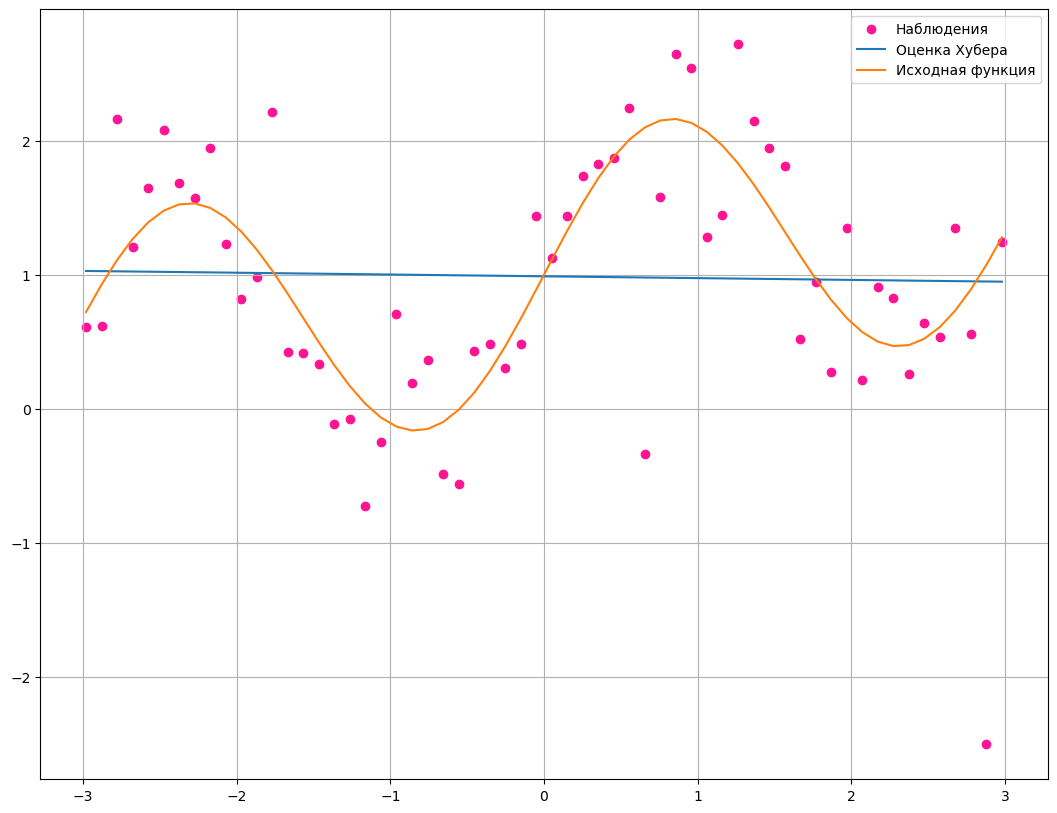

In [63]:
plt.figure(figsize=(13,10))
plt.scatter(h, Y_tukey, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_huber, label = 'Оценка Хубера')
plt.plot(h, Y_true_tukey, label = 'Исходная функция')
plt.legend()
plt.grid()

## Квантильная регрессия

In [66]:
H = np.array([np.ones(h.size), h]).T
theta =  np.linalg.lstsq(H, Y, rcond=None)[0]
print(f'theta OLS = {theta}')
modelLAD = LADRegression().fit(H, Y)
thetaLAD = modelLAD.coef_
Y_MNM =modelLAD.predict(H)
print(f'theta LAD = {thetaLAD}')

theta OLS = [1.01695361 0.04316177]
theta LAD = [0.5263189  0.04552599]


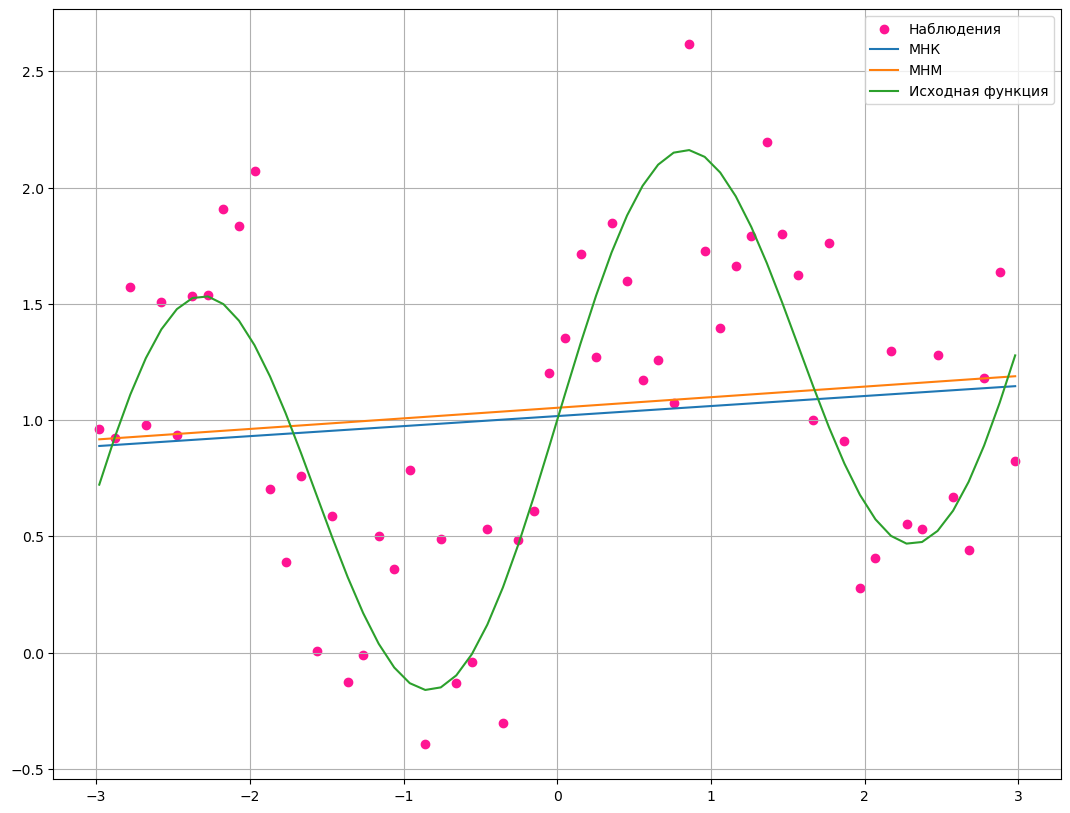

In [67]:
Y_LR = theta[0] + theta[1] * h
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR, label = 'МНК')
plt.plot(h,Y_MNM, label = 'МНМ')
plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()

In [68]:
MNK_test = theta[0]+theta[1]*h_test
MSE_MNK =np.sum((Y_test - MNK_test) ** 2)
print(f"MSE_MNK {MSE_MNK}")
MNM_test = thetaLAD[0]+thetaLAD[1]*h_test
MSE_MNM =np.sum((Y_test - MNM_test) ** 2)
print(f"MSE_MNM {MSE_MNM}")

MSE_MNK 64.25808451495975
MSE_MNM 75.18778030539156


In [74]:
qr0 = QuantileRegressor(quantile=0.2).fit(H, Y)
theta_qr0 = qr0.coef_
Yqr0 = qr0.predict(H)
print(f"alpha =0, theta = {theta_qr0}  ")
Yqr0_test = theta_qr0[0]+theta_qr0[1]*h_test
MSE_Yqr0 =np.sum((Y_test - Yqr0_test) ** 2)
print(f"MSE_MNK {MSE_Yqr0}")
qr005 = QuantileRegressor(quantile=0.4).fit(H, Y)
theta_qr005 = qr005.coef_
Yqr005 = qr005.predict(H)
print(f"alpha =0, theta = {theta_qr005}  ")
Yqr005_test = theta_qr005[0]+theta_qr005[1]*h_test
MSE_Yqr005 =np.sum((Y_test - Yqr005_test) ** 2)
print(f"MSE_MNK {MSE_Yqr005}")
qr01 = QuantileRegressor(quantile=0.6).fit(H, Y)
theta_qr01 = qr01.coef_
Yqr01 = qr01.predict(H)
print(f"alpha =0, theta = {theta_qr01}  ")
Yqr01_test = theta_qr01[0]+theta_qr01[1]*h_test
MSE_Yqr01 =np.sum((Y_test - Yqr01_test) ** 2)
print(f"MSE_MNK {MSE_Yqr01}")
qr03 = QuantileRegressor(quantile=0.7).fit(H, Y)
theta_qr03 = qr03.coef_
Yqr03 = qr03.predict(H)
print(f"alpha =0, theta = {theta_qr03}  ")
Yqr03_test = theta_qr03[0]+theta_qr03[1]*h_test
MSE_Yqr03 =np.sum((Y_test - Yqr03_test) ** 2)
print(f"MSE_MNK {MSE_Yqr03}")

alpha =0, theta = [-7.21208721e-17 -1.76985257e-15]  
MSE_MNK 125.81912736562352
alpha =0, theta = [-2.74849524e-13  9.50021848e-14]  
MSE_MNK 125.81912736560872
alpha =0, theta = [1.03581162e-13 3.31659166e-14]  
MSE_MNK 125.81912736560078
alpha =0, theta = [2.07155723e-10 2.40255536e-11]  
MSE_MNK 125.81912733837189


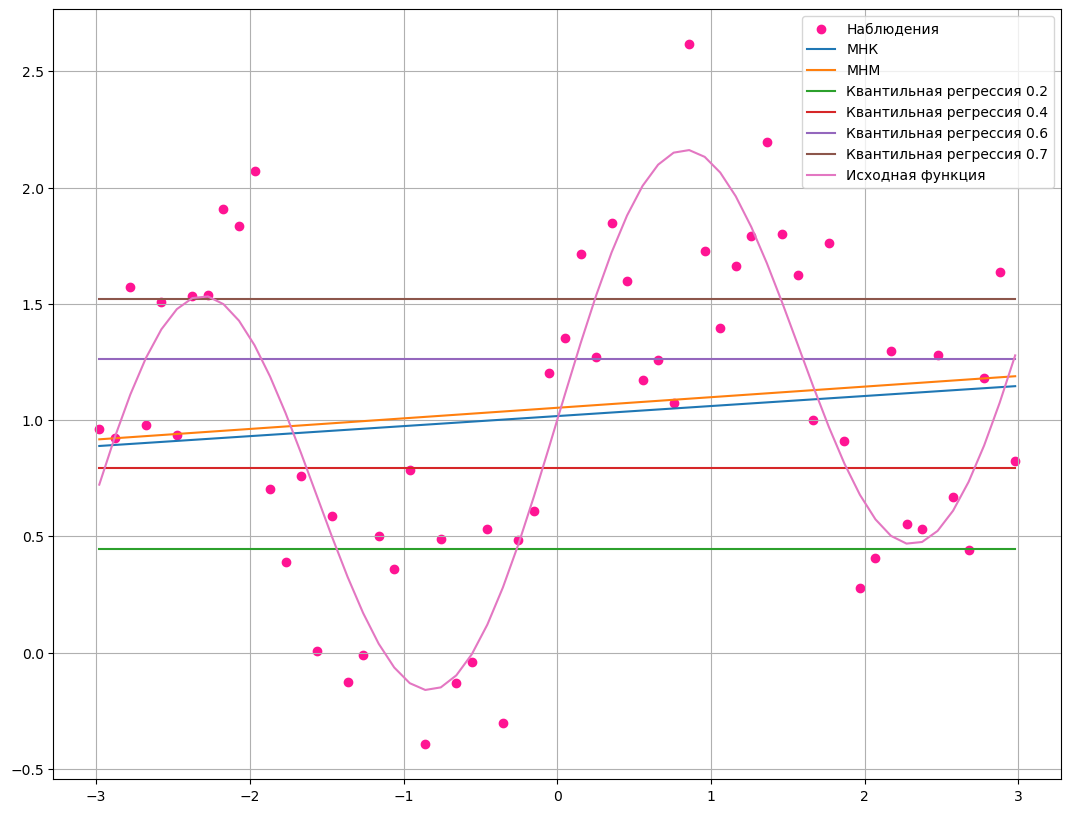

In [73]:
Y_LR = theta[0] + theta[1] * h
plt.figure(figsize=(13,10))
plt.scatter(h, Y, color = 'deeppink', label='Наблюдения')
plt.plot(h,Y_LR, label = 'МНК')
plt.plot(h,Y_MNM, label = 'МНМ')
plt.plot(h,Yqr0, label = 'Квантильная регрессия 0.2')
plt.plot(h,Yqr005, label = 'Квантильная регрессия 0.4')
plt.plot(h,Yqr01, label = 'Квантильная регрессия 0.6')
plt.plot(h,Yqr03, label = 'Квантильная регрессия 0.7')



plt.plot(h, Y_true, label = 'Исходная функция')
plt.legend()
plt.grid()